In [1]:
import numpy as np
import numpy.linalg as l
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from bops.rbm import RestrictedBoltzmannMachine

/Users/deu/.pyenv/versions/3.8.9/envs/bops/lib/python3.8/site-packages/numpy_ml/rl_models/rl_utils.py:25: DependencyWarning: Agents in `numpy_ml.rl_models` use the OpenAI gym for training. To install the gym environments, run `pip install gym`. For more information, see https://github.com/openai/gym.
  warnings.warn(fstr, DependencyWarning)
/Users/deu/Projects/CAR/bops/src/bops/rbm.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
teacher = RestrictedBoltzmannMachine(n_visible=5, n_hidden=3)
student = RestrictedBoltzmannMachine(n_visible=5, n_hidden=6)

teacher.xavier_initialization()
student.xavier_initialization()

In [15]:
batch, n = teacher.sample_initial_batch(batch_size=1)

In [16]:
train_set = teacher.sample_gibbs(n_burn=10000, n_steps=10000, return_hidden=False)

In [17]:
history = student.train(v=train_set, batch_size=50, n_epochs=10)

Cov L2 Diff: 5.77e-01:   0%|          | 0/10 [00:00<?, ?it/s]

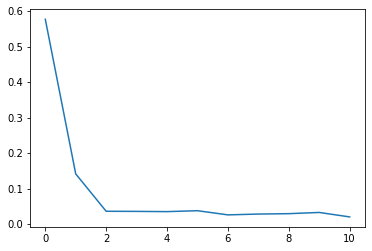

In [18]:
plt.plot(history)

In [19]:
test_set = teacher.sample_gibbs(n_burn=10000, n_steps=10000, batch_size=1, return_hidden=False)

In [20]:
predict = student.sample_gibbs(n_burn=10000, n_steps=10000, batch_size=1, return_hidden=False)

In [21]:
test_set.mean(axis=0)

array([0.7721, 0.9859, 0.2741, 0.1107, 0.7278])

In [22]:
predict.mean(axis=0)

array([0.7733, 0.9825, 0.2646, 0.1242, 0.7251])

In [23]:
l.norm(np.cov(predict.T) - np.cov(test_set.T)) / (l.norm(np.cov(predict.T))+l.norm(np.cov(test_set.T)))

0.021795413877240294

# Checking predictions

In [24]:
v = np.array([[1.,1.,1.,0.,0.]])

In [25]:
pred_teach = teacher.sample_gibbs(v_start=v, mask_updates=v[0], n_burn=100, n_steps=1000)

In [26]:
pred_stud = student.sample_gibbs(v_start=v, mask_updates=v[0], n_burn=100, n_steps=1000)

In [27]:
val_teach, counts_teach = np.unique(pred_teach[:,-2:],axis=0,return_counts=True)
val_teach = [str(tuple(val)) for val in val_teach]

In [28]:
teach_predictions = dict(zip(val_teach, counts_teach))

In [29]:
val_stud, counts_stud = np.unique(pred_stud[:,-2:],axis=0,return_counts=True)
val_stud = [str(tuple(val)) for val in val_stud]
stud_predictions = dict(zip(val_stud, counts_stud))

In [30]:
predictions = pd.concat([
    pd.Series(teach_predictions).reset_index().rename({0:'count','index':'val'}, axis='columns').assign(model='teacher'),
    pd.Series(stud_predictions).reset_index().rename({0:'count','index':'val'}, axis='columns').assign(model='student')
])

In [31]:
predictions

,val,count,model
0,"(0.0, 0.0)",236,teacher
1,"(0.0, 1.0)",647,teacher
2,"(1.0, 0.0)",30,teacher
3,"(1.0, 1.0)",87,teacher
0,"(0.0, 0.0)",241,student
1,"(0.0, 1.0)",652,student
2,"(1.0, 0.0)",29,student
3,"(1.0, 1.0)",78,student


<AxesSubplot:xlabel='val', ylabel='count'>

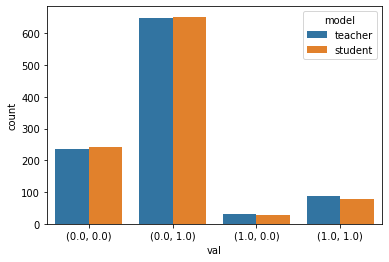

In [32]:
sns.barplot(data=predictions, x='val', y='count', hue='model')